In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from sklearn import metrics
import sklearn.linear_model
from sklearn.metrics import (roc_curve, roc_auc_score)

In [11]:
def plot_ROC(y_pred, y):
    '''plot ROC curve'''
    fpr, tpr, _ = roc_curve(y, y_pred)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')

def _plot_est_vs_true_regression(y_pred, y_true):
    target_name = getattr(y_true, "name", "target")
    bins = int(min(30, max(5, len(y_true) / 100.)))
    
    plt.hist2d(y_pred.values, y_true.values, (bins, bins), cmap=cm.jet,
               norm=mpl.colors.LogNorm())

    plt.ylabel("true {}".format(target_name))
    plt.xlabel("predicted {}".format(target_name))
        
    plt.plot(
        plt.gca().get_ylim(),
        plt.gca().get_ylim(),
        ls="-",
        c="w",
        lw=3,
        label="X=Y line")
    # plot regression line of y_true vs y_pred
    # here y_pred is y and y_true is y

    lm = sklearn.linear_model.LinearRegression().fit(
        [[x] for x in y_pred], [[x] for x in y_true])
    xs = [min(y_pred), max(y_pred)]
    plt.plot(xs,
             lm.predict([[x] for x in xs]),
             color='red',
             linestyle='-',
             linewidth=2,
             label="Regression line")

    plt.legend(loc=0, fontsize=10)
    plt.colorbar(fraction=0.05)


def _plot_est_vs_true_classification(y_pred, y_true):
    target_name = getattr(y_true, "name", "target")
    n_bins = (min(100, max(5, len(y_true) / 40.)), 2)
    plt.hist2d(y_pred.values, y_true.values, n_bins, cmap=cm.jet)
    plt.ylabel("true {}".format(target_name))
    plt.xlabel("predicted probability of {}=={}".format(y_true.name,
                                                        max(y_true)))
    plt.colorbar(fraction=0.05)
    vals = pd.unique(y_true)
    min_pop = min(len(pd.unique(y_pred[y_true == vals[0]])), len(
        pd.unique(y_pred[y_true == vals[1]])))
    if min_pop > 200:
        plt.scatter(y_pred.iloc[:100].values,
                    [0.25 if y == 0 else 0.75 for y in y_true[:100]],
                    alpha=0.4, color="white")
    else:
        plt.scatter(y_pred.values, [0.25 if y == 0 else 0.75 for y in y_true],
                    alpha=0.2, color="white")

    plt.grid()


def _plot_confidence_levels(y_true, y_pred, qs=np.arange(0, 0.6, 0.01)):
    '''draw panel showing fraction of measurements within some interval
    around y_pred'''

    frac_error = (y_pred-y_true).abs()/y_true
    y_true_bin_labels, _ = pd.qcut(y_true, 5, retbins=True)
    frac_error_groups = frac_error.groupby(y_true_bin_labels)

    n_within_interval = [frac_error_groups.apply(lambda frac_error_group:
                         (frac_error_group < q).sum()) for q in qs]
    n_in_group = frac_error_groups.size()
    frac_within_interval = [100*x/n_in_group for x in n_within_interval]

    for y_true_bin in y_true_bin_labels.cat.categories:
          frac = [frac_within_interval[iq].loc[y_true_bin] for iq in range(len(qs))]
          plt.plot(qs, frac, label=y_true_bin)

    frac = [100*(frac_error < q).mean() for q in qs]
    plt.plot(qs, frac, label='ALL', lw=3)

    plt.legend(loc=0, fontsize=6)
    plt.xlabel("Fractional error", fontsize=10)
    plt.ylabel("Percentage within interval", fontsize=10)
    plt.title("Percent of y_true within some fractional error of y_pred",
              fontsize=10)
    plt.grid()


def _plot_error_histogram(y_true, y_pred):
    ratio = y_pred/y_true
    ratio = ratio[~np.isinf(ratio)]
    plt.hist(ratio.values, bins=40)
    plt.xlabel("Predicted/True {}".format(y_true.name), fontsize=10)
    plt.grid()


def _write_performance_metrics(y_true, y_pred):
    bias = np.mean(y_pred - y_true)
    lbias = np.mean((y_pred - y_true) / y_true)

    plt.figtext(0.95, 0.45, "({} ev)".format(len(y_true)),
                family="monospace")
    plt.figtext(0.95, 0.40, "explained variance score : {:.3}".format(
                metrics.explained_variance_score(y_true, y_pred)),
                family="monospace")
    plt.figtext(0.95, 0.35, "mean absolute error      : {:.3}".format(
                metrics.mean_absolute_error(y_true, y_pred)),
                family="monospace")
    median_absolute_error = np.median((y_pred - y_true).abs())
    median_absolute_lerror = np.median(((y_pred - y_true) / y_true).abs())
    plt.figtext(0.95, 0.30,
                "median absolute error    : {:.3} ({:.0} %)".format
                (median_absolute_error, 100 * median_absolute_lerror),
                family="monospace")
    plt.figtext(0.95, 0.20, "r^2                      : {:.3}".format(
                metrics.r2_score(y_true, y_pred)), family="monospace")
    plt.figtext(0.95, 0.15, "bias                     : {:.3} ({:.0} %)"
                .format(bias, 100 * lbias), family="monospace")


def evaluate_performance_regression(y_true, y_pred):
    fig = plt.gcf()

    fig.add_subplot(2, 1, 1)
    _plot_est_vs_true_regression(y_pred, y_true)

#     fig.add_subplot(2, 2, 2)
#     _plot_confidence_levels(y_true, y_pred)

    fig.add_subplot(2, 1, 2)
    _plot_error_histogram(y_true, y_pred)

    _write_performance_metrics(y_true, y_pred)
    plt.tight_layout()


def evaluate_performance_classification(X, y_true, y_pred, y_pred_binary):
    fig = plt.gcf()
    fig.add_subplot(2, 1, 1)
    _plot_est_vs_true_classification(y_pred, y_true)

    fig.add_subplot(2, 3, 4)
    plot_ROC(y_pred, y_true)

    fig.add_subplot(2, 3, 5)
    true_vals = np.sort(pd.unique(y_true))
    for atrue_val in true_vals:
        vals_to_plot = y_pred.loc[y_true == atrue_val]
        label = "{}={}".format(y_true.name, atrue_val)
        plt.hist(vals_to_plot.values, normed=True, bins=20, alpha=0.3, label=label)
    plt.xlabel("Predicted prob of {}={}".format(y_true.name, true_vals[1]))
    plt.xlim(xmin=0, xmax=1)
    plt.ylabel("Relative frequency")
    plt.legend(loc=0)

    plt.figtext(0.7, 0.45, "({} ev)".format(len(y_true)),
                family="monospace")
    plt.figtext(0.7, 0.20, metrics.classification_report(
        y_true.tolist(), y_pred_binary), family="monospace")
    cm = metrics.confusion_matrix(y_true, y_pred_binary)

    plt.figtext(0.7, 0.15, "Confusion matrix:", family="monospace")
    plt.figtext(0.7, 0.10, cm, family="monospace")
    plt.tight_layout()

# Evaluate performance regression

In [12]:
X = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]), columns=['a', 'b', 'c'])
y_true = pd.Series(np.array([0.5, 0.4, 0.7, 0.7]), index=X.index)
y_pred = pd.Series(np.array([0.6, 0.2, 0.8, 0.9]), index=X.index)
y_pred_binary = pd.DataFrame(np.array([1, 0, 1, 1]), index=X.index)

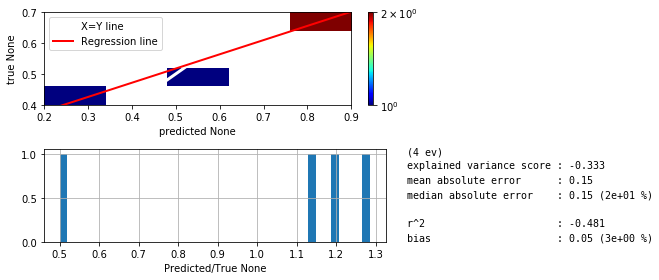

In [13]:
evaluate_performance_regression(y_true, y_pred)

# Evaluate performance classification

In [65]:
X = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]), columns=['a', 'b', 'c'])
y_true = pd.Series(np.array([1, 0, 1, 0]), index=X.index)
y_pred = pd.Series(np.array([0.6, 0.2, 0.8, 0.9]), index=X.index)
y_pred_binary = pd.DataFrame(np.array([1, 0, 1, 1]), index=X.index)

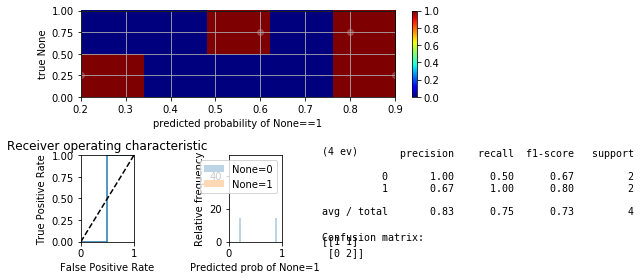

In [67]:
evaluate_performance_classification(X, y_true, y_pred, y_pred_binary)